In [10]:
from project import Projection
from Problem import Problem
from main_dynamic import run_experiment, load_config
from Phase1 import solve_CQ_feasible
from Phase2_1_obj import optim_Universal
from utils import visualize_pareto_front

In [11]:
import autograd.numpy as np
from autograd import jacobian
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
import pandas as pd
import math

# Prob

In [12]:
def f(x):
    return np.array([
        4*x[0]**2 + 4*x[1]**2,
        (x[0] - 5)**2 + (x[1] - 5)**2
    ])


#--------------- C --------------------#
def c1(x):
    return -(x[0] - 5)**2 - x[1]**2 + 25
def c2(x):
    return -(x[0] - 8)**2 - (x[1] + 3)**2 + 17.7


#--------------- Q --------------------#
def q1(y):
    return 50**2 - (y[0] - 50)**2 - (y[1] - 50)**2

def q_plus(y):
    center = 50.0
    radius_sq = 50**2  
    
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

# Hàm dùng cho Projection 
cons_C = (
    {
        'type': 'ineq', 'fun' : c1,     
    },
    {
        'type': 'ineq', 'fun' : c2,     
    }
)

dim_x = 2
bounds_x = Bounds([-15,-15],[30, 30])

cons_Q = (
    {
        'type': 'ineq', 'fun' : q1,     
    },    
)

cons_Qplus = (
    {'type': 'ineq', 'fun': q_plus},
)
dim_y = 2

In [13]:
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

# Setup Problem
prob = Problem(
    f=[f], jac_f=[jacobian(f)], C=[], Q=[], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

In [14]:
x_init = np.array([-10., -10.])

# Config

In [15]:
from ruamel.yaml import YAML
from ruamel.yaml.comments import CommentedSeq

def update_config(file_path, x_init_np):
    yaml = YAML()
    yaml.preserve_quotes = True
    yaml.indent(mapping=2, sequence=4, offset=2)

    with open(file_path, 'r', encoding='utf-8') as f_in:
        config = yaml.load(f_in)

    val_list = x_init_np.tolist() if hasattr(x_init_np, 'tolist') else x_init_np
    
    flow_list = CommentedSeq(val_list)
    flow_list.fa.set_flow_style() 

    config['initialization']['x_init'] = flow_list
    
    config['phase1']['gamma'] = 0.00055
    config['phase1']['max_iter'] = 300
    
    config['phase2']['mu'] = 1
    config['phase2']['init_params'] = 1
    config['phase2']['expo_alpha'] = 0.25
    config['phase2']['expo_lambda'] = 0.75
    config['phase2']['max_iter'] = 500

    # 3. Ghi lại vào file
    with open(file_path, 'w', encoding='utf-8') as f_in:
        yaml.dump(config, f_in)
    
    print(f"✅ Đã cập nhật xong file: {file_path}")

# --- CHẠY THỬ ---
config_file = 'config.yaml'
update_config(config_file, x_init)

with open(config_file, 'r', encoding='utf-8') as f_in:
    print("\nNội dung file sau khi sửa:")
    print(f_in.read())

✅ Đã cập nhật xong file: config.yaml

Nội dung file sau khi sửa:
data:
  test_ray:
    -   - 1.0
        - 0.0
    -   - 0.9965844930066698
        - 0.08257934547233232
    -   - 0.9863613034027223
        - 0.1645945902807339
    -   - 0.9694002659393304
        - 0.24548548714079912
    -   - 0.9458172417006346
        - 0.32469946920468346
    -   - 0.9157733266550574
        - 0.4016954246529694
    -   - 0.8794737512064891
        - 0.4759473930370735
    -   - 0.8371664782625285
        - 0.5469481581224268
    -   - 0.7891405093963936
        - 0.6142127126896678
    -   - 0.7357239106731316
        - 0.677281571625741
    -   - 0.6772815716257411
        - 0.7357239106731316
    -   - 0.6142127126896678
        - 0.7891405093963936
    -   - 0.5469481581224269
        - 0.8371664782625285
    -   - 0.4759473930370736
        - 0.8794737512064891
    -   - 0.40169542465296953
        - 0.9157733266550574
    -   - 0.32469946920468357
        - 0.9458172417006346
    -   - 0.245

# Solve

In [16]:
results = run_experiment(prob)

=== BẮT ĐẦU PHASE 1: TÌM ĐIỂM KHẢ THI ===
Khởi tạo: x0: [-10. -10.]
Chiếu lên C được: x: [ 4.0789 -4.5249]


100%|██████████| 300/300 [00:01<00:00, 177.79it/s]


+-----+------------------------+---------+--------------------------+------------------------+----------+-----------+
|  k  | x_new                  | gamma_k | y                        | z_proj                 |   e_x    |    e_f    |
+-----+------------------------+---------+--------------------------+------------------------+----------+-----------+
|  0  | [ 4.078929, -4.524861] | 0.0006  | [148.44813 ,  91.571358] | [96.061747, 69.450334] | 1.337432 | 56.865392 |
|  10 | [ 3.795915, -3.160212] | 0.0000  | [97.58365 , 68.038889]   | [96.75316 , 67.724051] | 0.001365 |  0.888164 |
|  20 | [ 3.795598, -3.151669] | 0.0000  | [97.35832 , 67.900288]   | [96.770538, 67.678145] | 0.000489 |  0.628359 |
|  30 | [ 3.795462, -3.147853] | 0.0000  | [97.25803 , 67.838412]   | [96.778388, 67.657363] | 0.000275 |  0.512675 |
|  40 | [ 3.795383, -3.145583] | 0.0000  | [97.198504, 67.801632]   | [96.783073, 67.644946] | 0.000180 |  0.443997 |
|  50 | [ 3.795329, -3.144018] | 0.0000  | [97.157483, 6

+-----+---------+--------+---------+----------+-----------------+---------+--------+--------+
|   k | Alpha_k | Lambda |     Eta | Step_len |          x_curr | S(F(x)) |  Gap C | Gap Q+ |
+-----+---------+--------+---------+----------+-----------------+---------+--------+--------+
|   0 |  1.0000 | 1.0000 | 44.9437 |   0.0223 | [ 3.036,-2.485] | 47.4398 | 0.0000 | 0.1694 |
|  50 |  0.3742 | 0.0524 |  2.9062 |   0.0180 | [ 4.383,-0.729] |  7.8834 | 0.1129 | 0.0000 |
| 100 |  0.3154 | 0.0314 |  2.8094 |   0.0112 | [ 4.352,-0.845] |  9.3340 | 0.0603 | 0.0000 |
| 150 |  0.2853 | 0.0232 |  2.5772 |   0.0090 | [ 4.338,-0.894] |  9.9684 | 0.0392 | 0.0000 |
| 200 |  0.2656 | 0.0187 |  2.4100 |   0.0078 | [ 4.331,-0.919] | 10.2936 | 0.0287 | 0.0000 |
| 250 |  0.2512 | 0.0159 |  6.2687 |   0.0025 | [ 4.295,-0.929] | 10.4828 | 0.0226 | 0.0000 |
| 300 |  0.2401 | 0.0138 |  2.1668 |   0.0064 | [ 4.323,-0.945] | 10.6281 | 0.0183 | 0.0000 |
| 350 |  0.2310 | 0.0123 |  2.0910 |   0.0059 | [ 4.321,-0.9

+-----+---------+--------+---------+----------+-----------------+---------+--------+--------+
|   k | Alpha_k | Lambda |     Eta | Step_len |          x_curr | S(F(x)) |  Gap C | Gap Q+ |
+-----+---------+--------+---------+----------+-----------------+---------+--------+--------+
|   0 |  1.0000 | 1.0000 | 16.2574 |   0.0615 | [ 3.608,-2.154] | 47.4398 | 0.0000 | 0.1694 |
|  50 |  0.3742 | 0.0524 |  6.8109 |   0.0077 | [ 4.422,-0.473] |  7.3185 | 0.1373 | 0.0000 |
| 100 |  0.3154 | 0.0314 |  5.8799 |   0.0053 | [ 4.44 ,-0.606] |  8.7614 | 0.0585 | 0.0000 |
| 150 |  0.2853 | 0.0232 |  5.3988 |   0.0043 | [ 4.446,-0.648] |  9.2176 | 0.0357 | 0.0000 |
| 200 |  0.2656 | 0.0187 |  5.0876 |   0.0037 | [ 4.449,-0.669] |  9.4368 | 0.0251 | 0.0000 |
| 250 |  0.2512 | 0.0159 |  2.8049 |   0.0057 | [ 4.482,-0.663] |  9.3522 | 0.0286 | 0.0000 |
| 300 |  0.2401 | 0.0138 |  2.8737 |   0.0048 | [ 4.481,-0.669] |  9.4293 | 0.0253 | 0.0000 |
| 350 |  0.2310 | 0.0123 |  2.7507 |   0.0045 | [ 4.481,-0.6

+-----+---------+--------+---------+----------+-----------------+---------+--------+--------+
|   k | Alpha_k | Lambda |     Eta | Step_len |          x_curr | S(F(x)) |  Gap C | Gap Q+ |
+-----+---------+--------+---------+----------+-----------------+---------+--------+--------+
|   0 |  1.0000 | 1.0000 | 20.4809 |   0.0488 | [ 3.678,-2.143] | 47.4398 | 0.0000 | 0.1694 |
|  50 |  0.3742 | 0.0524 |  2.7590 |   0.0190 | [ 4.59 ,-0.345] | 11.4859 | 0.0955 | 0.0000 |
| 100 |  0.3154 | 0.0314 |  2.3814 |   0.0132 | [ 4.626,-0.395] | 12.5290 | 0.0412 | 0.0000 |
| 150 |  0.2853 | 0.0232 |  2.7733 |   0.0084 | [ 4.641,-0.417] | 11.6351 | 0.0408 | 0.0000 |
| 200 |  0.2656 | 0.0187 |  2.5533 |   0.0073 | [ 4.647,-0.425] | 12.0111 | 0.0292 | 0.0000 |
| 250 |  0.2512 | 0.0159 |  2.4407 |   0.0065 | [ 4.65 ,-0.429] | 12.2208 | 0.0233 | 0.0000 |
| 300 |  0.2401 | 0.0138 |  2.3457 |   0.0059 | [ 4.652,-0.432] | 12.3543 | 0.0194 | 0.0000 |
| 350 |  0.2310 | 0.0123 |  2.2735 |   0.0054 | [ 4.653,-0.4

In [17]:
pf_cloud = np.load("test/ex4/target_space.npy")
pf_targets = np.load("test/ex4/pf_true.npy")

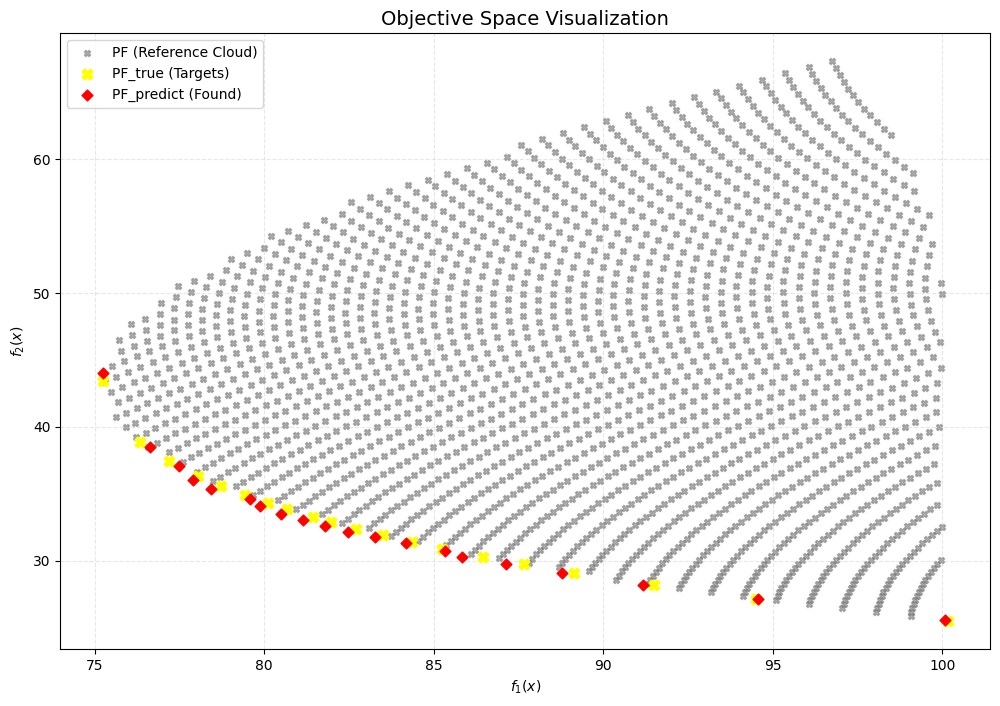

In [18]:
visualize_pareto_front(
    pf_pred=results["pareto_f"], 
    pf_cloud=pf_cloud,   
    pf_targets=pf_targets,
    title="Objective Space Visualization",
    figsize=(12, 8)
)

In [19]:
np.save("test/ex4/pf_dynamic_true.npy", results["pareto_f"])